In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import transformers

from sklearn.metrics import precision_score,recall_score,f1_score

import sys
sys.path.append("..")

/home/newdisk/jxh/anaconda/envs/sft2/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.22.3)
  from scipy.sparse import csr_matrix, issparse


In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
transformer_name = 'models/finbert'

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)
## usage：
# tokenizer("hello world!")
# tokenizer.tokenize("hello world!")
# tokenizer.encode("hello world!")
# tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

In [5]:
train_data, test_data = datasets.load_dataset("data/findata", split=["train", "eval"])
train_data = train_data.filter(lambda example: example["task"]=="FINFE" and ("积极" in example["output"] or "消极" in example["output"]))
test_data = test_data.filter(lambda example: example["task"]=="FINFE" and ("积极" in example["output"] or "消极" in example["output"]))

In [6]:
def tokenize_and_numericalize_example(example, tokenizer):
    if "积极" in example["output"]:
        label = 1
    elif "消极" in example["output"]:
        label = 0
    ids = tokenizer(example["input"], truncation=True)["input_ids"]
    return {"ids": ids, "label": label}

In [7]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

Map: 100%|██████████| 1460/1460 [00:00<00:00, 3395.04 examples/s]


In [9]:
pad_index = tokenizer.pad_token_id

In [10]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [11]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [12]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [13]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [14]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [15]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [39]:
output_dim = 2
freeze = True
transformer = transformers.AutoModel.from_pretrained(transformer_name)
model = Transformer(transformer, output_dim, freeze)

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,538 trainable parameters


In [41]:
lr = 1e-5
optimizer = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()   # nn.CrossEntropyLoss()  nn.MSELoss()

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [48]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
        
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [49]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
            all_labels.extend(label.cpu().numpy())
            all_predictions.extend(torch.argmax(prediction, dim=1).cpu().numpy())
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    return np.mean(epoch_losses), np.mean(epoch_accs), f1

In [50]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [51]:
metrics = collections.defaultdict(list)

In [52]:
n_epochs = 10
best_valid_loss = float("inf")



for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc, f1 = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    metrics["f1_score"].append(f1)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "ckpts/bert_sentiment.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")
    print(f"valid_f1: {f1:.3f}")

evaluating...: 100%|██████████| 376/376 [00:05<00:00, 68.66it/s]


epoch: 0
train_loss: 0.650, train_acc: 0.611
valid_loss: 0.627, valid_acc: 0.640
valid_f1: 0.534


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 68.07it/s]


epoch: 1
train_loss: 0.634, train_acc: 0.633
valid_loss: 0.611, valid_acc: 0.647
valid_f1: 0.551


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 68.14it/s]


epoch: 2
train_loss: 0.616, train_acc: 0.656
valid_loss: 0.598, valid_acc: 0.679
valid_f1: 0.621


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 68.70it/s]


epoch: 3
train_loss: 0.604, train_acc: 0.668
valid_loss: 0.586, valid_acc: 0.696
valid_f1: 0.654


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 65.72it/s]


epoch: 4
train_loss: 0.593, train_acc: 0.691
valid_loss: 0.577, valid_acc: 0.704
valid_f1: 0.667


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 66.64it/s]


epoch: 5
train_loss: 0.584, train_acc: 0.702
valid_loss: 0.568, valid_acc: 0.708
valid_f1: 0.673


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 69.19it/s]


epoch: 6
train_loss: 0.578, train_acc: 0.707
valid_loss: 0.561, valid_acc: 0.723
valid_f1: 0.699


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 69.43it/s]


epoch: 7
train_loss: 0.569, train_acc: 0.714
valid_loss: 0.554, valid_acc: 0.725
valid_f1: 0.703


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 64.40it/s]


epoch: 8
train_loss: 0.563, train_acc: 0.722
valid_loss: 0.548, valid_acc: 0.731
valid_f1: 0.708


evaluating...: 100%|██████████| 376/376 [00:05<00:00, 63.85it/s]


epoch: 9
train_loss: 0.559, train_acc: 0.721
valid_loss: 0.543, valid_acc: 0.735
valid_f1: 0.715


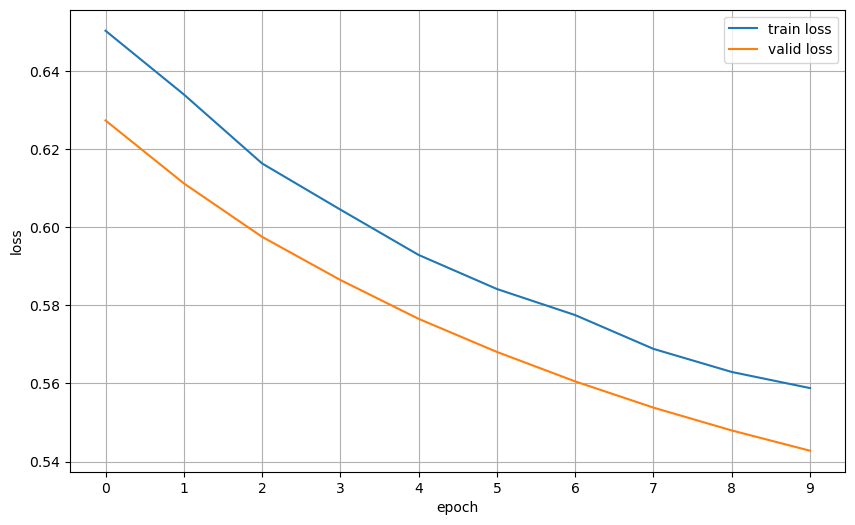

In [53]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

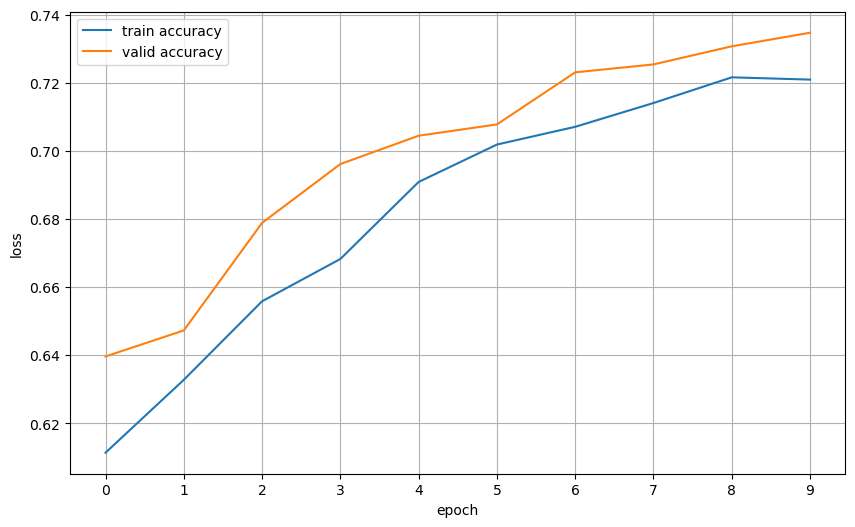

In [54]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [55]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc, test_f1 = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 183/183 [00:02<00:00, 64.46it/s]


In [56]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}, test_f1: {test_f1:.3f}")

test_loss: 0.533, test_acc: 0.742, test_f1: 0.724


In [57]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [58]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.5232451558113098)

In [59]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(1, 0.6564949154853821)

In [60]:
text = "银行股全线飘绿 平安银行跌4%"

predict_sentiment(text, model, tokenizer, device)

(1, 0.7832381129264832)

In [61]:
text = "平安银行理财子公司获批筹建：注册资本50亿 股份行第五家"

predict_sentiment(text, model, tokenizer, device)

(1, 0.9364389777183533)